# Lane Detection in Still Images

This part of the project implements lane detection using the Canny Edge Detector and the Hough Transform. Eexamples of the lane detection performance using this method are shown below:

<img src="lane_detect_example.jpg"/>

<img src="multiimg_example.jpg"/>

### Lane Detection in Still Images Pt 1: Dependencies

In [19]:
# 3rd party dependencies
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Lane Detection in Still Images Pt 2: Lane Detection Function

In [20]:
# set tuning parameters for algortithms
# gaussian blurring param:
kernel_size = 5  # Gaussian blur kernel must be odd number
# canny edge detection params:
low_thresh = 50  # low gradient threshold
hi_thresh = 150  # high gradient threshold
# hough transform params:
rho = 1  # distance resolution of the accumulator in pixels
theta = np.pi / 180  # angle resolution of the accumulator in radians
threshold = 2  # votes needed to return line (>threshold).
min_line_len = 10
max_line_gap = 30

def detect(raw_image):
    white_mask = cv2.inRange(raw_image, np.array([200, 200, 200]), np.array([255, 255, 255]))
    yellow_mask = cv2.inRange(raw_image, np.array([120, 120, 0]), np.array([255, 255, 100]))
    combo_mask = cv2.bitwise_or(white_mask, yellow_mask)
    color_image = cv2.bitwise_and(raw_image, raw_image, mask=combo_mask)
    gray_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)

    # gaussian blur + canny edge detection
    gaussian_image = cv2.GaussianBlur(gray_image, (kernel_size, kernel_size), 0)
    edges_image = cv2.Canny(gaussian_image, low_thresh, hi_thresh)

    # crop into left and right images for finding left and right lane lines
    left_mask = np.zeros_like(edges_image)
    right_mask = np.zeros_like(edges_image)
    imshape = raw_image.shape
    vertices_left = np.array([[(75, imshape[0] - 25), (imshape[1] / 2 - 50, imshape[0] / 2 + 75),
                          (imshape[1] / 2, imshape[0] / 2 + 75), (imshape[1] / 2, imshape[0] - 25)]], dtype=np.int32)

    vertices_right = np.array([[(imshape[1] / 2, imshape[0] - 25), (imshape[1] / 2, imshape[0] / 2 + 75),
                               (imshape[1] / 2 + 50, imshape[0] / 2 + 75), (imshape[1] - 75, imshape[0] - 25)]],
                             dtype=np.int32)
    cv2.fillPoly(left_mask, vertices_left, 255)
    cv2.fillPoly(right_mask, vertices_right, 255)
    masked_edges_image_left = cv2.bitwise_and(edges_image, left_mask)
    masked_edges_image_right = cv2.bitwise_and(edges_image, right_mask)

    # compute lines via hough transform
    left_lines = cv2.HoughLinesP(masked_edges_image_left, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
    right_lines = cv2.HoughLinesP(masked_edges_image_right, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)

    processed_image = np.copy(raw_image) # create img copy

    if left_lines is not None:
        # compute "average" line by performing linear regression on hough line endpoints
        leftYs = np.array([y1 for [[x1,y1,x2,y2]] in left_lines] + [y2 for [[x1,y1,x2,y2]] in left_lines])
        leftXs = np.array([x1 for [[x1,y1,x2,y2]] in left_lines] + [x2 for [[x1,y1,x2,y2]] in left_lines])
        leftA = np.vstack([leftXs, np.ones(len(leftXs))]).T
        left_M, left_B = np.linalg.lstsq(leftA, leftYs)[0]
        left_Y1 = imshape[0]
        left_X1 = (left_Y1 - left_B) / left_M
        left_Y2 = imshape[0] / 2 + 100
        left_X2 = (left_Y2 - left_B) / left_M
        # draw lane lines
        cv2.line(processed_image, (int(left_X1), int(left_Y1)), (int(left_X2), int(left_Y2)), (255, 0, 0), 5)  # draw lines

    if right_lines is not None:
        # compute "average" line by performing linear regression on hough line endpoints
        rightYs = np.array([y1 for [[x1,y1,x2,y2]] in right_lines] + [y2 for [[x1,y1,x2,y2]] in right_lines])
        rightXs = np.array([x1 for [[x1,y1,x2,y2]] in right_lines] + [x2 for [[x1,y1,x2,y2]] in right_lines])
        rightA = np.vstack([rightXs, np.ones(len(rightXs))]).T
        right_M, right_B = np.linalg.lstsq(rightA, rightYs)[0]
        right_Y1 = imshape[0]
        right_X1 = (right_Y1 - right_B) / right_M
        right_Y2 = imshape[0] / 2 + 100
        right_X2 = (right_Y2 - right_B) / right_M
        # draw lane lines 
        cv2.line(processed_image, (int(right_X1), int(right_Y1)), (int(right_X2), int(right_Y2)), (255, 0, 0), 5)  # draw lines

    return processed_image

### Lane Detection in Still Images Pt 3: Processing Pipeline

processed image:  result_images/whiteCarLaneSwitch.jpg
processed image:  result_images/solidYellowCurve2.jpg
processed image:  result_images/solidYellowCurve.jpg
processed image:  result_images/solidWhiteCurve.jpg
processed image:  result_images/solidYellowLeft.jpg
processed image:  result_images/solidWhiteRight.jpg
LANE DETECTION ON ALL STILL IMAGES:


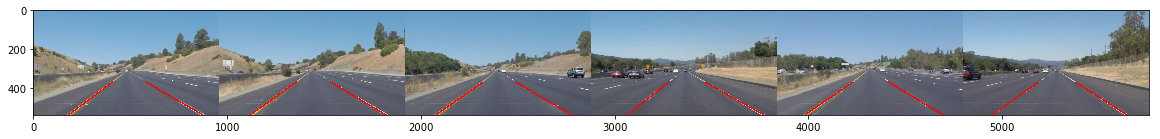

In [22]:
# prepare filesystem for input and output
in_dir_name = "test_images/"
out_dir_name = "result_images/"
if os.path.exists(out_dir_name):
    shutil.rmtree(out_dir_name)
os.mkdir(out_dir_name)
input_image_filenames = os.listdir(in_dir_name)

# execute lane lines detection for each provided image
big_image = None  # concatenated image with all still examples 
for image_filename in input_image_filenames:
    print("processed image: ", os.path.join(out_dir_name, image_filename))
    # read raw image
    raw_image = mpimg.imread(os.path.join(in_dir_name, image_filename))
    # perform line detection. see detect.py
    processed_image = detect(raw_image)
    # save processed images to disk
    fig = plt.figure(frameon=False)
    fig.set_size_inches(20, 10)
    plt.imshow(processed_image)
    plt.savefig(os.path.join(out_dir_name, "processed_" + image_filename), dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()
    if big_image is None:
        big_image = processed_image
    else:
        big_image = np.concatenate((big_image, processed_image), axis=1)
# display concatenated image
fig = plt.figure(frameon=False)
fig.set_size_inches(20,10)
plt.imshow(big_image)
print("LANE DETECTION ON ALL STILL IMAGES:")
plt.savefig("multiimg_example.jpg", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

# Lane Detection in Videos

### Lane Detection in Videos Pt 1: Processing Pipeline

In [23]:
in_video_dir_name = "test_videos"
out_video_dir_name = "result_videos"
if os.path.exists(out_video_dir_name):
    shutil.rmtree(out_video_dir_name)
os.mkdir(out_video_dir_name)
input_video_filenames = os.listdir(in_video_dir_name)

for video_filename in input_video_filenames:
    clip = VideoFileClip(os.path.join(in_video_dir_name, video_filename))
    processed_clip = clip.fl_image(detect)
    processed_clip_name = os.path.join(out_video_dir_name, "processed_" + video_filename)
    processed_clip.write_videofile(processed_clip_name, audio=False)
    print("processed video: ", processed_clip_name)

[MoviePy] >>>> Building video result_videos/processed_solidWhiteRight.mp4
[MoviePy] Writing video result_videos/processed_solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:02<00:00, 101.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_videos/processed_solidWhiteRight.mp4 

processed video:  result_videos/processed_solidWhiteRight.mp4
[MoviePy] >>>> Building video result_videos/processed_challenge.mp4
[MoviePy] Writing video result_videos/processed_challenge.mp4


100%|██████████| 251/251 [00:04<00:00, 62.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_videos/processed_challenge.mp4 

processed video:  result_videos/processed_challenge.mp4
[MoviePy] >>>> Building video result_videos/processed_solidYellowLeft.mp4
[MoviePy] Writing video result_videos/processed_solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:06<00:00, 97.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_videos/processed_solidYellowLeft.mp4 

processed video:  result_videos/processed_solidYellowLeft.mp4


### Lane Detection in Videos Pt 2: Example Video Results

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("result_videos/processed_solidWhiteRight.mp4"))

In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("result_videos/processed_solidYellowLeft.mp4"))

### Lane Detection in Videos Pt 3: Example Results on Optional Challenge Video

In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("result_videos/processed_challenge.mp4"))